In [2]:
import sys; sys.path.append('/Users/racheloaks-leaf/Desktop/retinanalysis/src/retinanalysis')
import importlib
import retinanalysis as ra
importlib.reload(ra)
importlib.reload(ra.analysis_chunk)
import pandas as pd
import numpy as np
ra.settings.mea_config
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Run below if needing to update the database
# ra.database_pop.reload_celltypefiles()
# ra.database_utils.populate_database()

[2025-07-03 15:52:22,443][INFO]: Connecting root@127.0.0.1:3306
[2025-07-03 15:52:22,490][INFO]: Connected root@127.0.0.1:3306


In [3]:
df = ra.get_datasets_from_protocol_names('matfiles')
df


Found 1 protocols matching "matfiles":
['edu.washington.riekelab.protocols.PresentMatFiles']

Found 1 experiments, 1 epoch blocks.



,exp_name,datafile_name,NDF,chunk_name,protocol_name,is_mea,data_dir,group_label,experiment_id,protocol_id,group_id,block_id,chunk_id
0,20250514C,data003,0.5,movies_images,edu.washington.riekelab.protocols.PresentMatFiles,1,20250514C/data003,PresentMatFiles,125,74,2295,3386,488


In [4]:
s1 = ra.StimBlock(df.at[0, 'exp_name'], df.at[0, 'datafile_name'])
ac1 = ra.AnalysisChunk(df.at[0, 'exp_name'], s1.nearest_noise_chunk)

Loading VCD from /Volumes/data/analysis/20250514C/chunk1/kilosort2.5 ...
VCD loaded with 781 cells.
Loaded spatial maps for channels [0, 2] and 781 cells of shape (127, 203, 2)
Spatial maps have been padded to align with RF parameters.


(127, 203, 2)

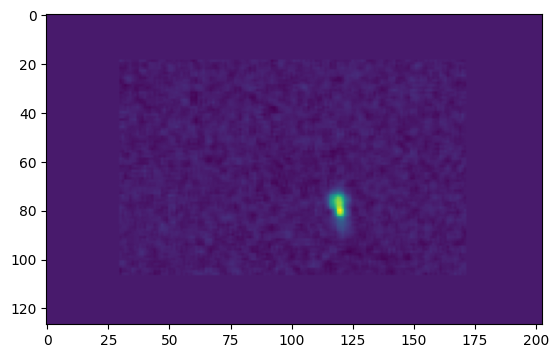

In [5]:
cell_idx = 10
cell_id = ac1.cell_ids[cell_idx]
display(ac1.d_spatial_maps[cell_id].shape)
plt.imshow(ac1.d_spatial_maps[cell_id][:,:,0])

Correlation matrix computation

In [6]:
sm_flat = [sm.flatten() for sm in ac1.d_spatial_maps.values()]
sm_flat = np.array(sm_flat)

ei_flat = [ac1.vcd.get_ei_for_cell(id).ei.flatten() for id in ac1.cell_ids]
ei_flat = np.array(ei_flat)

sm_corr = np.corrcoef(sm_flat)
ei_corr = np.corrcoef(ei_flat)

np.nan_to_num(sm_corr, copy=False, nan = 0, posinf = 0, neginf = 0)
np.nan_to_num(ei_corr, copy=False, nan = 0, posinf = 0, neginf = 0);

/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


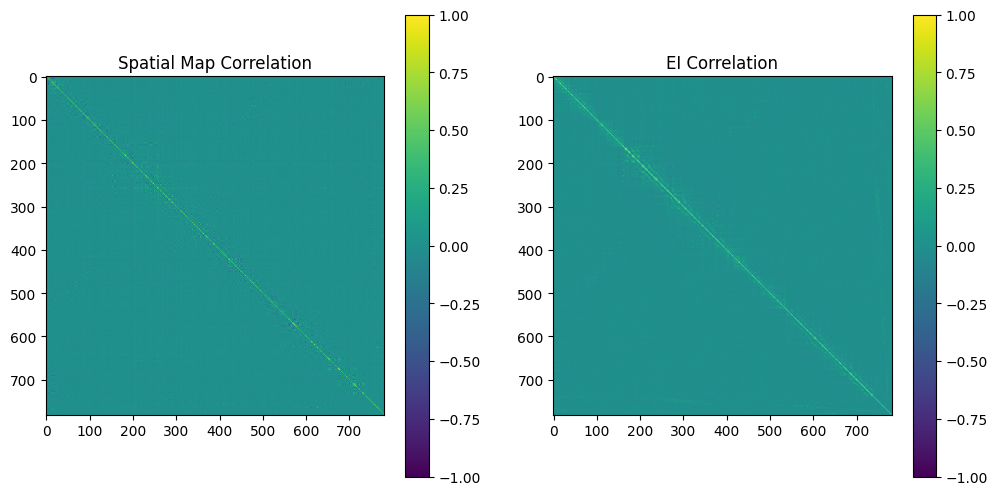

In [7]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
im = axs[0].imshow(sm_corr, cmap='viridis', vmin=-1, vmax=1)
axs[0].set_title('Spatial Map Correlation')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(ei_corr, cmap='viridis', vmin=-1, vmax=1)
axs[1].set_title('EI Correlation')
plt.colorbar(im, ax=axs[1])

In [4]:
#start with a noise file

df_1 = ra.get_datasets_from_protocol_names('.SpatialNoise')
df_1[df_1['exp_name'] == '20250514C']


Found 2 protocols matching ".spatialnoise":
['manookinlab.protocols.SpatialNoise'
 'manookinlab.protocols.SpatialNoiseAndMotion']

Found 44 experiments, 198 epoch blocks.



,exp_name,datafile_name,NDF,chunk_name,protocol_name,is_mea,data_dir,group_label,experiment_id,protocol_id,group_id,block_id,chunk_id
177,20250514C,data000,0.5,chunk1,manookinlab.protocols.SpatialNoise,1,20250514C/data000,Spatial Noise,125,26,2293,3383,485
178,20250514C,data001,0.5,chunk1,manookinlab.protocols.SpatialNoise,1,20250514C/data001,Spatial Noise,125,26,2293,3384,485
179,20250514C,data006,0.5,chunk2,manookinlab.protocols.SpatialNoise,1,20250514C/data006,Spatial Noise 30 R*,125,26,2298,3389,486
180,20250514C,data010,0.5,chunk3,manookinlab.protocols.SpatialNoise,1,20250514C/data010,noise photopic,125,26,2302,3393,492


In [5]:
sb = ra.StimBlock(df_1.at[177, 'exp_name'], df_1.at[177, 'datafile_name'])
ac = ra.AnalysisChunk(df_1.at[177, 'exp_name'], sb.nearest_noise_chunk)

Loading VCD from /Volumes/data/analysis/20250514C/chunk1/kilosort2.5 ...
VCD loaded with 781 cells.
Loaded spatial maps for channels [0, 2] and 781 cells of shape (127, 203, 2)
Spatial maps have been padded to align with RF parameters.


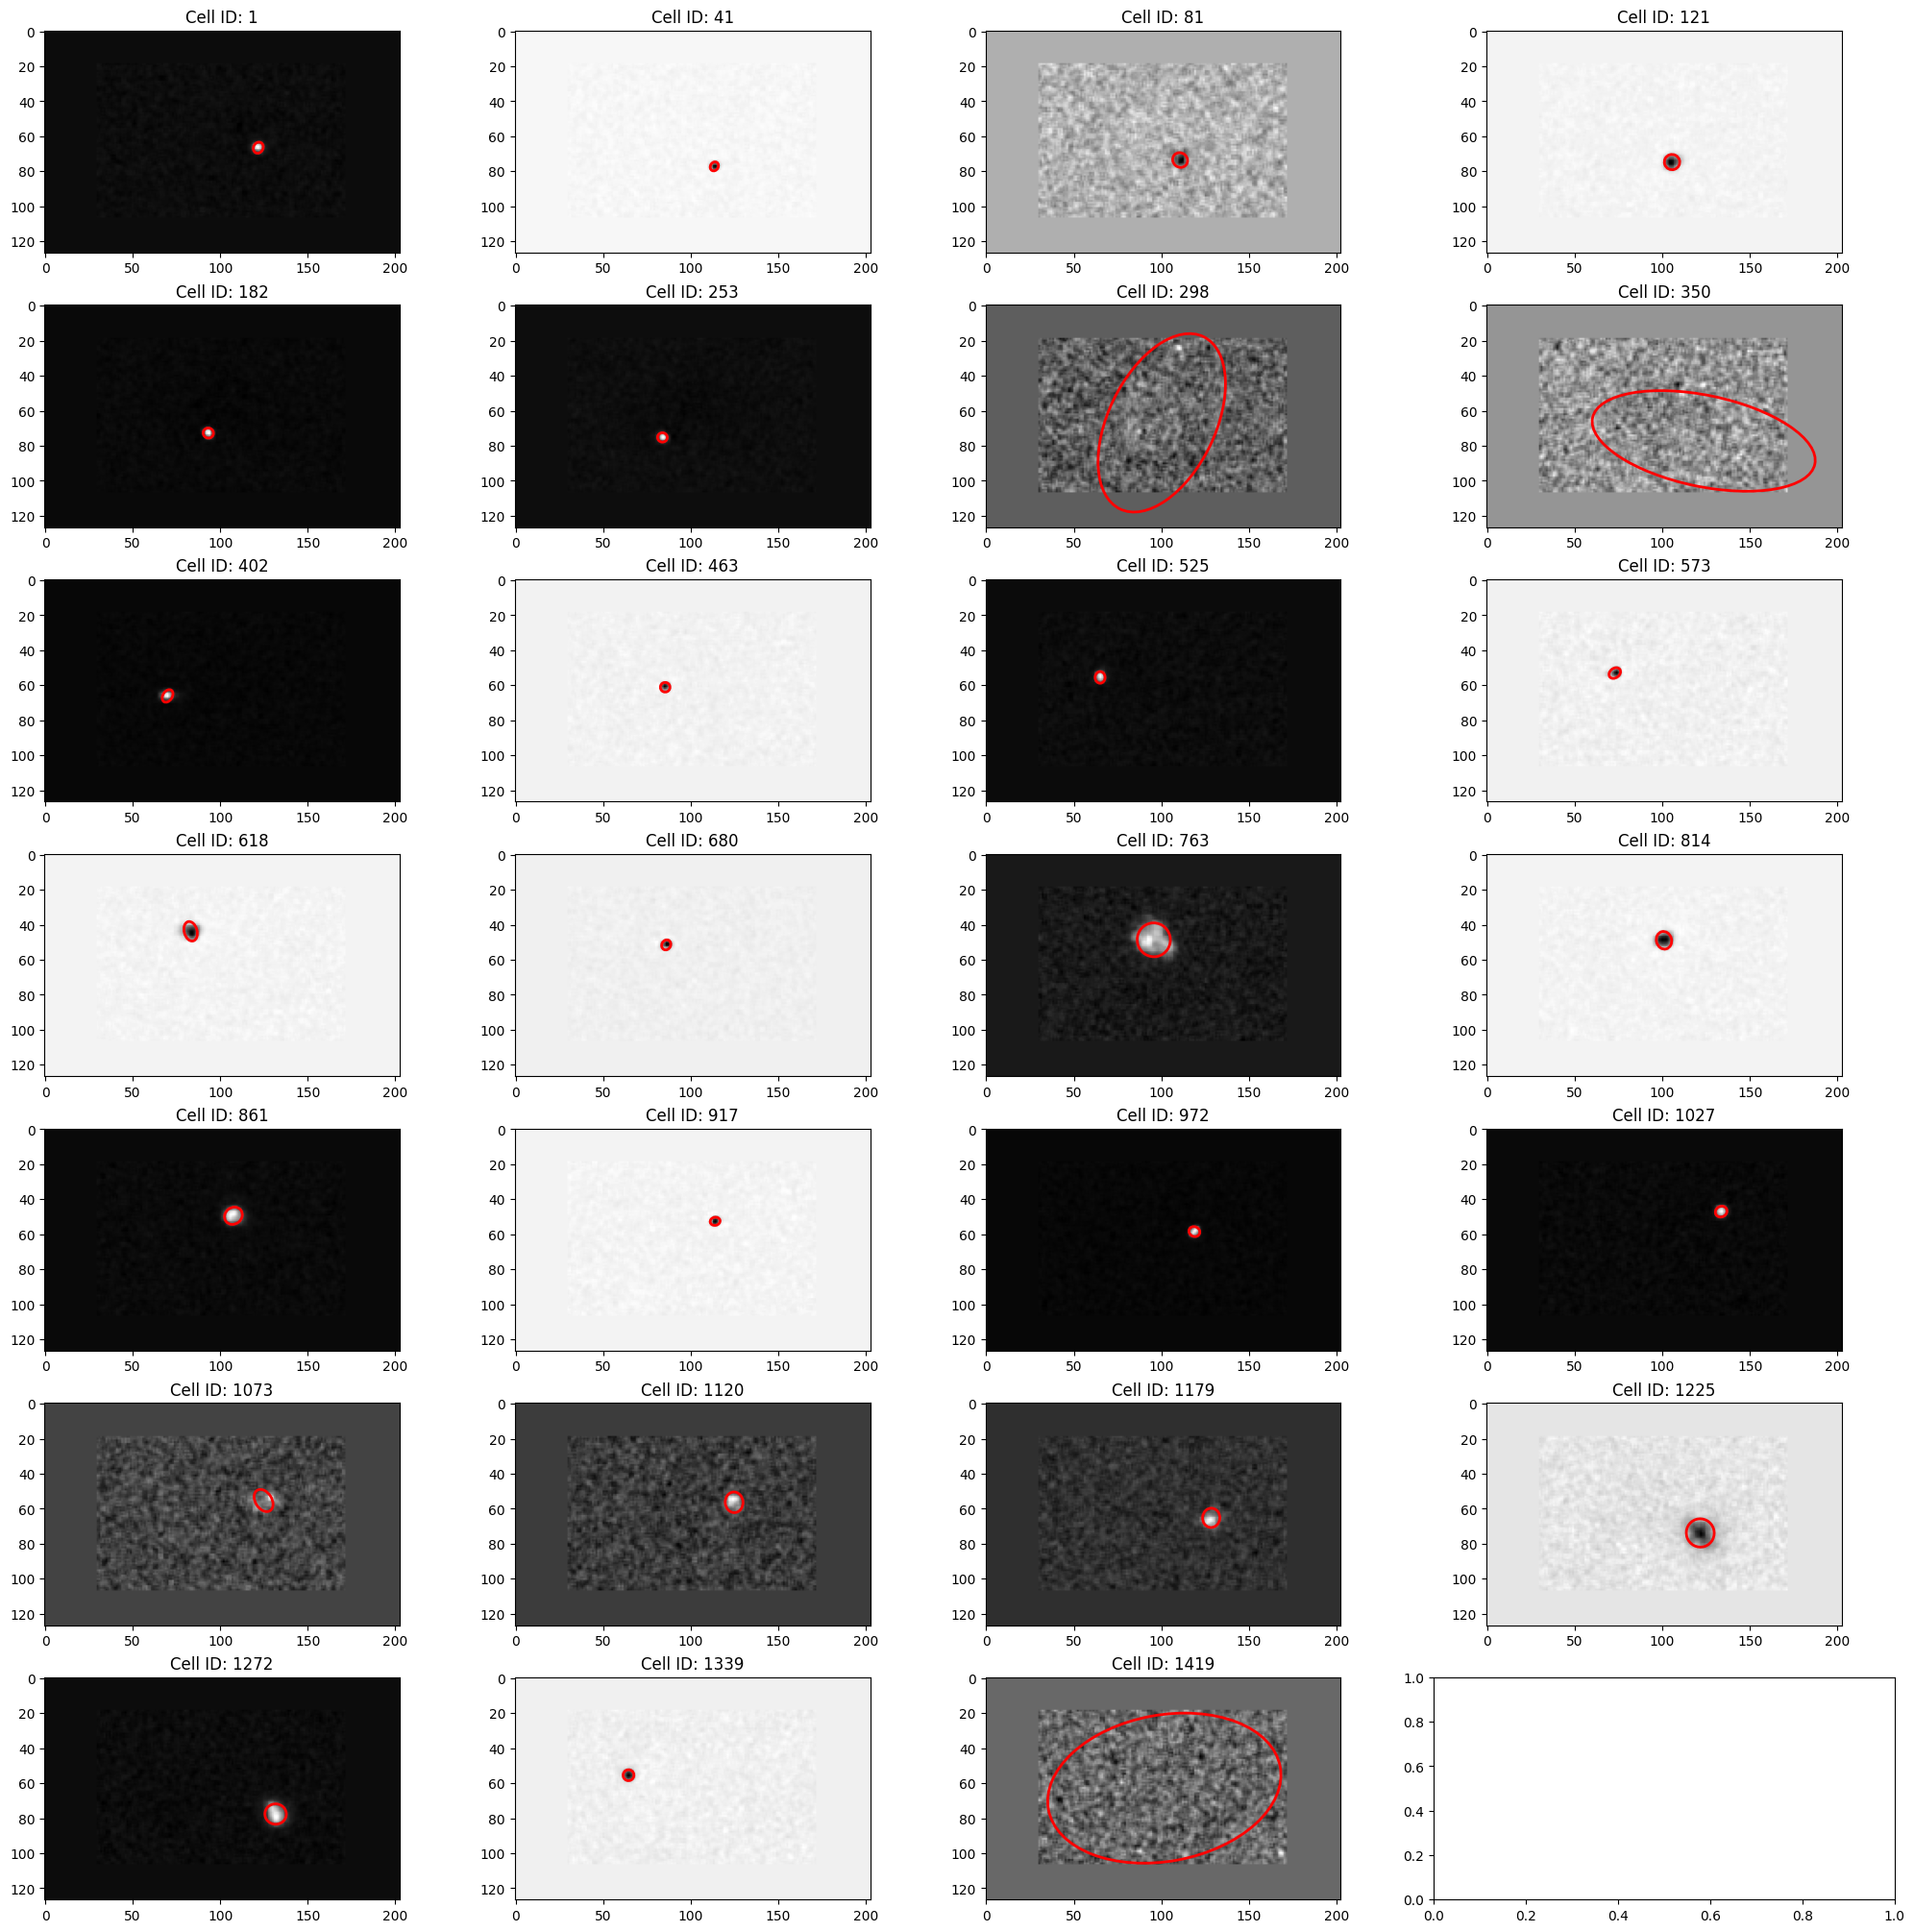

In [10]:
#confirmation that padding worked as expected

test_ids = ac.cell_ids[::30]
fig, ax = plt.subplots(int(np.ceil((len(test_ids)/4))), np.min([4, (len(test_ids)-1%4)+1]), figsize=(20, 20), constrained_layout=True)
ax= ax.flatten()
for idx, cell in enumerate(test_ids):
    ax[idx].imshow(ac.d_spatial_maps[cell][:,:,0], cmap='gray')
    subset = ac.df_cell_params[ac.df_cell_params['cell_id'] == cell]
    rf_params = [subset['center_x'].values[0],
                    subset['center_y'].values[0],
                    subset['std_x'].values[0],
                    subset['std_y'].values[0],
                    subset['rot'].values[0]]
    ellipse = Ellipse(xy=(rf_params[0], rf_params[1]),
                      width=rf_params[2]*2, height=rf_params[3]*2,
                      angle=np.rad2deg(rf_params[4]), 
                      edgecolor='red', facecolor='none', lw=2)
    ax[idx].add_patch(ellipse)
    ax[idx].set_title(f'Cell ID: {cell}')



In [11]:
sm_flat = [sm.flatten() for sm in ac.d_spatial_maps.values()]
sm_flat = np.array(sm_flat)

ei_flat = [ac.vcd.get_ei_for_cell(id).ei.flatten() for id in ac.cell_ids]
ei_flat = np.array(ei_flat)

sm_corr = np.corrcoef(sm_flat)
ei_corr = np.corrcoef(ei_flat)

np.nan_to_num(sm_corr, copy=False, nan = 0, posinf = 0, neginf = 0)
np.nan_to_num(ei_corr, copy=False, nan = 0, posinf = 0, neginf = 0);

/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


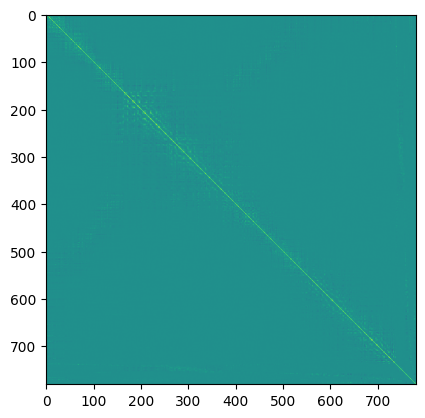

In [21]:
ei_corr = ra.ei_corr(ac.vcd, ac.vcd, method='full')
plt.imshow(ei_corr, cmap='viridis', vmin=-1, vmax=1)

In [14]:
cluster_to_index = dict(zip(ac.cell_ids, range(len(ac.cell_ids))))

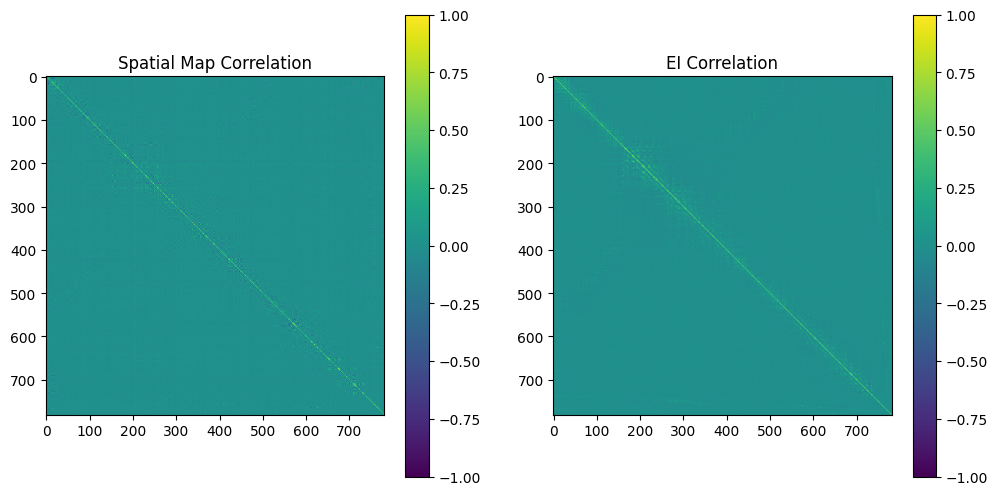

In [15]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
im = axs[0].imshow(sm_corr, cmap='viridis', vmin=-1, vmax=1)
axs[0].set_title('Spatial Map Correlation')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(ei_corr, cmap='viridis', vmin=-1, vmax=1)
axs[1].set_title('EI Correlation')
plt.colorbar(im, ax=axs[1])

number of high ei correlation pairs: 1
number of high spatial map correlation pairs: 25
intersection: 0


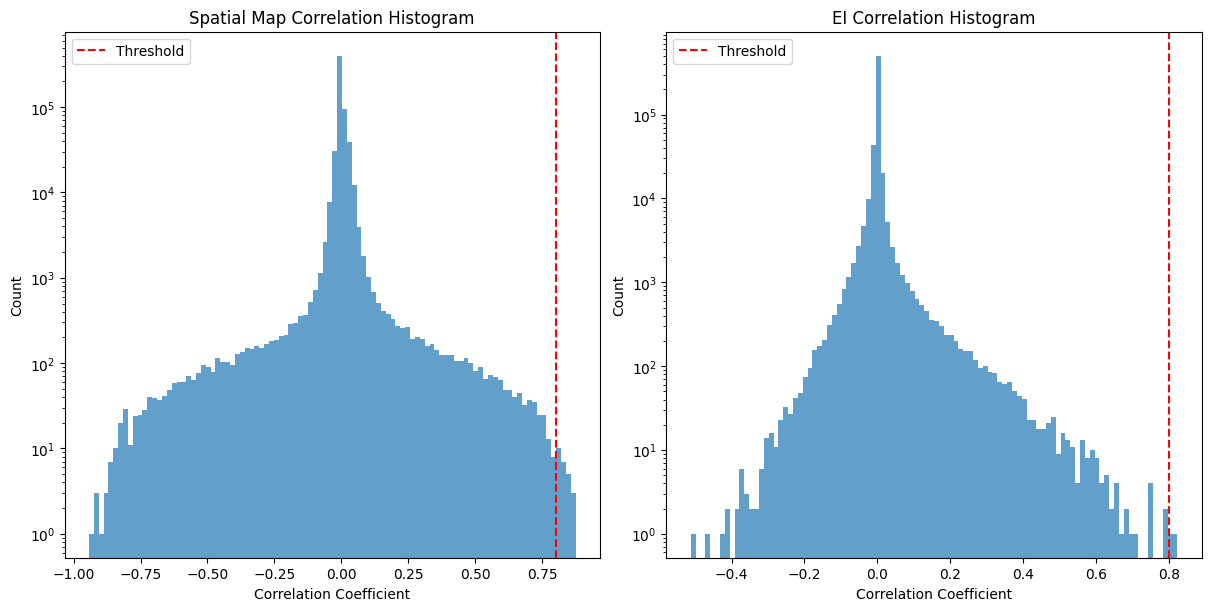

In [22]:
import copy
threshold_sm = 0.80
threshold_ei = 0.80

# Identify cells with high spatial map correlation
#remove self-correlations (diagonal of the correlation matrix)
sm_upper_tri = copy.deepcopy(sm_corr)
sm_upper_tri = np.triu(sm_upper_tri, k=1)  # Keep only upper triangle of the correlation matrix
high_sm_idx = np.where(sm_upper_tri > threshold_sm)
high_sm_corr_cells = set([(ac.cell_ids[high_sm_idx[0][i]], ac.cell_ids[high_sm_idx[1][i]]) for i in range(len(high_sm_idx[0]))]) # Get the indices of cells with high spatial map correlation
high_sm_idx_set = set([(high_sm_idx[0][i], high_sm_idx[1][i]) for i in range(len(high_sm_idx[0]))]) # Combine indices of both cells in the pair

ei_upper_tri = copy.deepcopy(ei_corr)
ei_upper_tri = np.triu(ei_upper_tri, k=1)  # Keep only upper triangle of the correlation matrix
high_ei_idx = np.where(ei_upper_tri > threshold_ei)
high_ei_corr_cells = set([(ac.cell_ids[high_ei_idx[0][i]], ac.cell_ids[high_ei_idx[1][i]]) for i in range(len(high_ei_idx[0]))]) # Get the indices of cells with high EI correlation
high_ei_idx_set = set([(high_ei_idx[0][i], high_ei_idx[1][i]) for i in range(len(high_ei_idx[0]))]) # Combine indices of both cells in the pair

# all_problem_cells = np.unique(np.array([ac.cell_ids[high_ei_idx[0][:]], ac.cell_ids[high_ei_idx[1][:]], ac.cell_ids[high_sm_idx[0][:]], ac.cell_ids[high_sm_idx[1][:]]]).flatten())

fig, ax = plt.subplots(1,2, figsize=(12, 6), constrained_layout=True)
ax[0].hist(sm_upper_tri.flatten(), bins=100, alpha=0.7)
ax[0].semilogy()
ax[0].set_title('Spatial Map Correlation Histogram')
ax[0].set_xlabel('Correlation Coefficient')
ax[0].set_ylabel('Count')
ax[1].hist(ei_upper_tri.flatten(), bins=100, alpha=0.7)
ax[1].semilogy()
ax[1].set_title('EI Correlation Histogram')
ax[1].set_xlabel('Correlation Coefficient')
ax[1].set_ylabel('Count')
ax[0].axvline(threshold_sm, color='red', linestyle='--', label='Threshold')
ax[1].axvline(threshold_ei, color='red', linestyle='--', label='Threshold')
ax[0].legend()
ax[1].legend()
print(f'number of high ei correlation pairs: {len(high_ei_corr_cells)}')
print(f'number of high spatial map correlation pairs: {len(high_sm_corr_cells)}')
print(f'intersection: {len(high_ei_corr_cells.intersection(high_sm_corr_cells))}')


In [23]:
#index ac.cell_ids by target clusters
all_problem_cells = {item for tuple in high_sm_corr_cells.union(high_ei_corr_cells) for item in tuple}
all_sm_cells = {item for tuple in high_sm_corr_cells for item in tuple}
all_ei_cells = {item for tuple in high_ei_corr_cells for item in tuple}

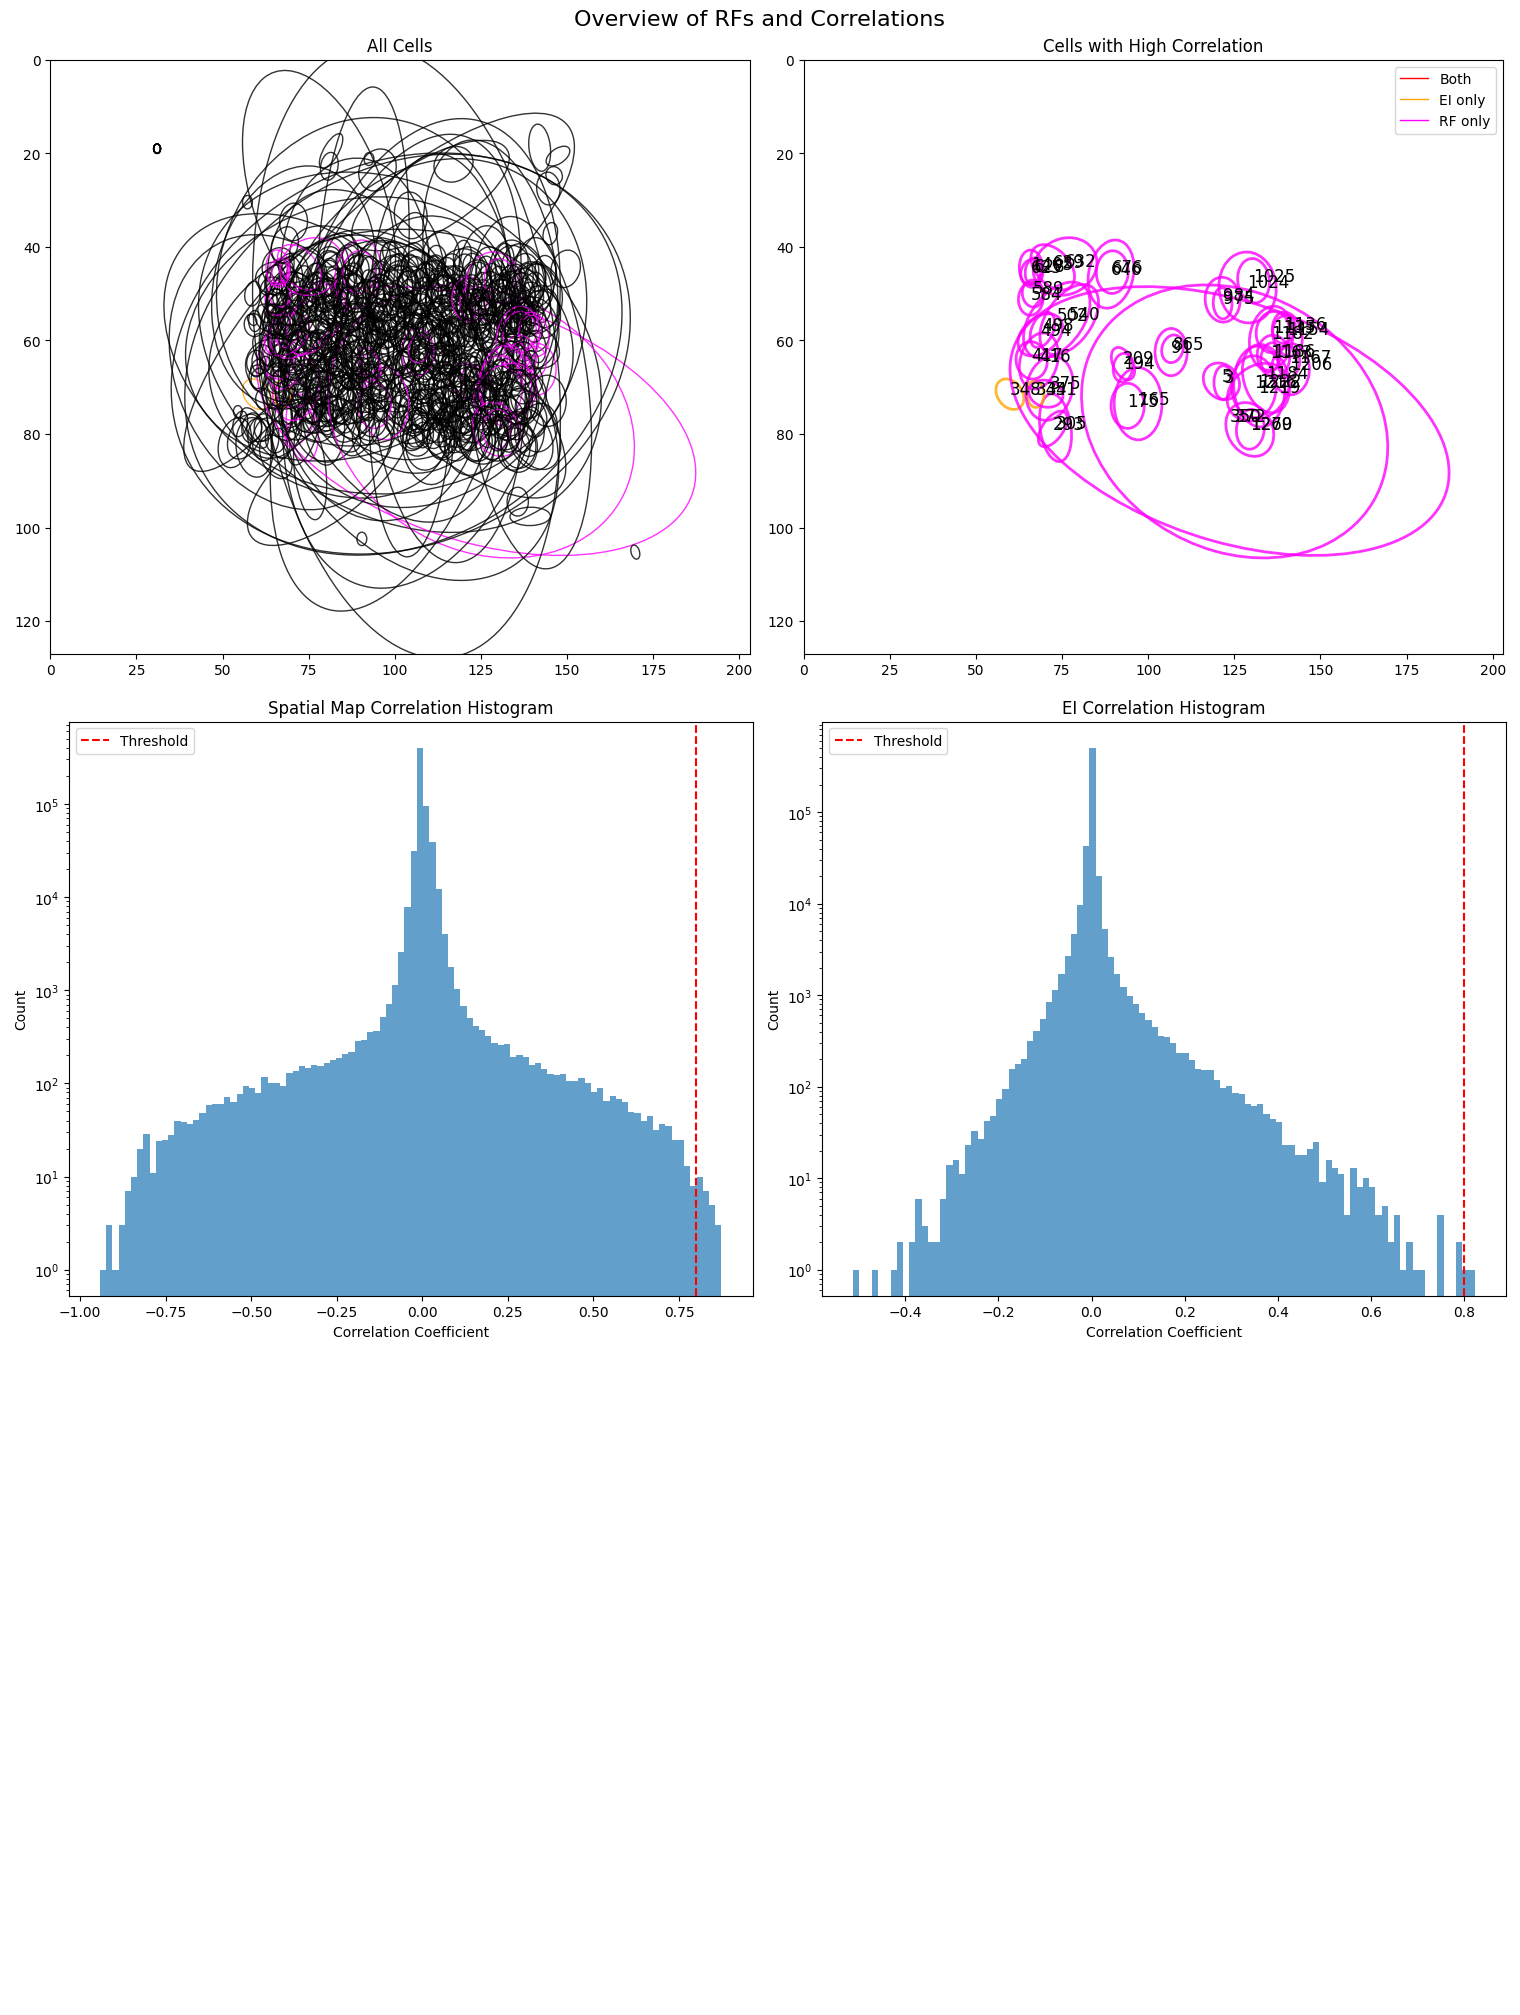

In [24]:
from matplotlib.lines import Line2D
rf_params = ac.rf_params
fig = plt.figure(figsize=(15, 20), layout='compressed')
fig.suptitle('Overview of RFs and Correlations', fontsize=16)
subfigs = fig.subfigures(3, 1) 
ax00 = subfigs[0].subplots(1, 2)
for cell in ac.cell_ids:
    ell1 = Ellipse(xy=(rf_params[cell]['center_x'], rf_params[cell]['center_y']),
                width=rf_params[cell]['std_x']*2, height=rf_params[cell]['std_y']*2,
                angle=np.rad2deg(rf_params[cell]['rot']), 
                edgecolor='None', facecolor='None', lw=2, alpha=0.8)
    if cell in all_ei_cells and cell in all_sm_cells:
        ell1.set_edgecolor('red')
        color = 'red'
        ax00[1].add_patch(ell1)
        ax00[1].annotate(f'{cell}', xy=(rf_params[cell]['center_x'], rf_params[cell]['center_y']), fontsize=12)
    elif cell in all_ei_cells:
        ell1.set_edgecolor('orange')
        color = 'orange'
        ax00[1].add_patch(ell1)
        ax00[1].annotate(f'{cell}', xy=(rf_params[cell]['center_x'], rf_params[cell]['center_y']), fontsize=12)
    elif cell in all_sm_cells:
        ell1.set_edgecolor('magenta')
        color = 'magenta'
        ax00[1].add_patch(ell1)
        ax00[1].annotate(f'{cell}', xy=(rf_params[cell]['center_x'], rf_params[cell]['center_y']), fontsize=12)
    else:
        color = 'black'
    ell = Ellipse(xy=(rf_params[cell]['center_x'], rf_params[cell]['center_y']),
                  width=rf_params[cell]['std_x']*2, height=rf_params[cell]['std_y']*2,
                  angle=np.rad2deg(rf_params[cell]['rot']), 
                  edgecolor=color, facecolor='None', lw=1, alpha=0.8)
    ax00[0].add_patch(ell)
ax00[0].set_xlim(0, ac.numXChecks)
ax00[0].set_ylim(ac.numYChecks, 0) 
ax00[1].set_xlim(0, ac.numXChecks)
ax00[1].set_ylim(ac.numYChecks, 0)  # Invert y-axis to match spatial map orientation
ax00[0].set_title('All Cells')
ax00[1].set_title('Cells with High Correlation')
custom_lines = [Line2D([0], [0], color='red', lw=1, label='Both'),
                    Line2D([0], [0], color='orange', lw=1, label='EI only'),
                    Line2D([0], [0], color='magenta', lw=1, label='RF only')]
ax00[1].legend(handles=custom_lines, loc='upper right')

ax01 = subfigs[1].subplots(1, 2)
ax01[0].hist(sm_upper_tri.flatten(), bins=100, alpha=0.7)
ax01[0].semilogy()
ax01[0].set_title('Spatial Map Correlation Histogram')
ax01[0].set_xlabel('Correlation Coefficient')
ax01[0].set_ylabel('Count')
ax01[1].hist(ei_upper_tri.flatten(), bins=100, alpha=0.7)
ax01[1].semilogy()
ax01[1].set_title('EI Correlation Histogram')
ax01[1].set_xlabel('Correlation Coefficient')
ax01[1].set_ylabel('Count')
ax01[0].axvline(threshold_sm, color='red', linestyle='--', label='Threshold')
ax01[1].axvline(threshold_ei, color='red', linestyle='--', label='Threshold')
ax01[0].legend()
ax01[1].legend()


In [25]:
high_ei_corr_cells

{(344, 348)}

In [26]:
high_sm_corr_cells

{(3, 5),
 (91, 865),
 (165, 175),
 (194, 209),
 (293, 305),
 (350, 372),
 (351, 375),
 (416, 417),
 (494, 498),
 (502, 540),
 (584, 589),
 (625, 628),
 (625, 1405),
 (629, 632),
 (646, 676),
 (975, 984),
 (1024, 1025),
 (1135, 1182),
 (1136, 1154),
 (1163, 1186),
 (1167, 1206),
 (1184, 1222),
 (1216, 1222),
 (1219, 1222),
 (1269, 1270)}

Text(0.5, 0.98, 'EI Corr: 0.52, SM Corr: 0.85')

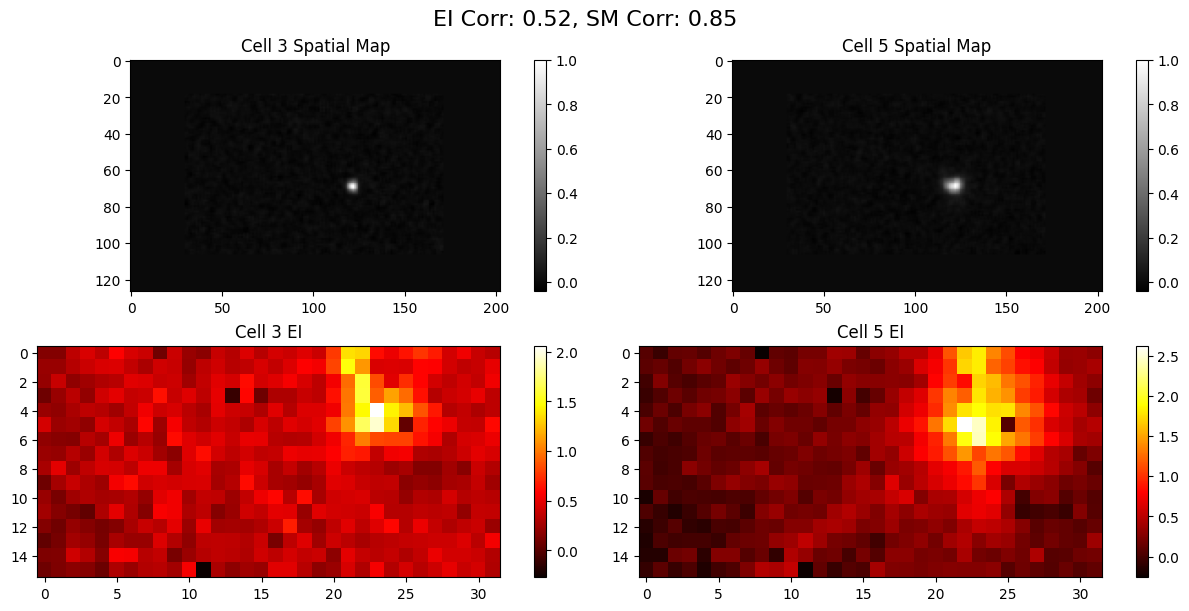

In [27]:
cell_a = 3
cell_b = 5

ei_1 = ac.vcd.get_ei_for_cell(cell_a).ei
ei_2 = ac.vcd.get_ei_for_cell(cell_b).ei
sorted_electrodes = ra.sort_electrode_map(ac.vcd.get_electrode_map())
e1_1 = ra.reshape_ei(ei_1, sorted_electrodes)
e1_2 = ra.reshape_ei(ei_2, sorted_electrodes)
e1_1 = np.log10(np.max(np.abs(e1_1), axis=2)+1e-6)
e1_2 = np.log10(np.max(np.abs(e1_2), axis=2)+1e-6)

fig, ax = plt.subplots(2, 2, figsize=(12, 6), constrained_layout=True)
im1=ax[0,0].imshow(ac.d_spatial_maps[cell_a][:,:,0], cmap='gray')
im2=ax[0,1].imshow(ac.d_spatial_maps[cell_b][:,:,0], cmap='gray')
ax[0,0].set_title(f'Cell {cell_a} Spatial Map')
ax[0,1].set_title(f'Cell {cell_b} Spatial Map')
im3=ax[1,0].imshow(e1_1, cmap='hot')
im4=ax[1,1].imshow(e1_2, cmap='hot')
ax[1,0].set_title(f'Cell {cell_a} EI')
ax[1,1].set_title(f'Cell {cell_b} EI')
plt.colorbar(im1, ax=ax[0,0])
plt.colorbar(im2, ax=ax[0,1])
plt.colorbar(im3, ax=ax[1,0])
plt.colorbar(im4, ax=ax[1,1])
fig.suptitle(f'EI Corr: {ei_corr[cluster_to_index[cell_a], cluster_to_index[cell_b]]:.2f}, SM Corr: {sm_corr[cluster_to_index[cell_a], cluster_to_index[cell_b]]:.2f}', fontsize=16)


In [31]:
ac

AnalysisChunk with properties:
  exp_name: 20250514C
  chunk_name: chunk1
  ss_version: kilosort2.5
  noise_protocol: manookinlab.protocols.SpatialNoise
  data_files: ['data000', 'data001']
  typing_files: ['dragos_kilosort2.5.classification.txt']
  numXChecks: 203
  numYChecks: 127
  staXChecks: 142
  staYChecks: 88
  canvas_size: [1824, 1140]
  microns_per_pixel: 3.37
  cell_ids of length: 781
  rf_params with fiels: ['center_x', 'center_y', 'std_x', 'std_y', 'rot']
  df_cell_params of shape: (781, 7)
  d_spatial_maps with 781 cells

In [ ]:
amps = np.load('/Volumes/data/data/sorted/20250514C/chunk1/kilosort2.5/amplitudes.npy')
templates = np.load('/Volumes/data/data/sorted/20250514C/chunk1/kilosort2.5/spike_templates.npy')

In [43]:
templates_vision = templates + 1
amplitudes = np.vstack((np.squeeze(amps), np.squeeze(templates_vision)))


In [ ]:
a = amplitudes[:,amplitudes[1,:]==cell_a]
print(a.shape)

(2, 11640)


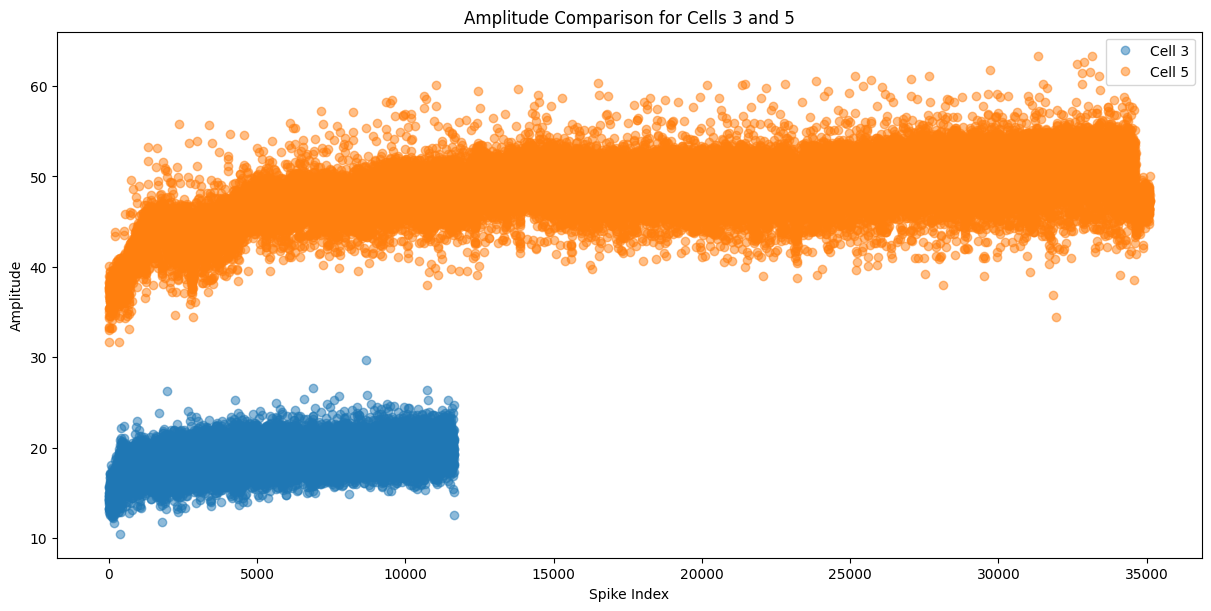

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
ax.plot(amplitudes[0,amplitudes[1,:]==cell_a], 'o', label=f'Cell {cell_a}', alpha=0.5)
ax.plot(amplitudes[0,amplitudes[1,:]==cell_b], 'o', label=f'Cell {cell_b}', alpha=0.5)
ax.set_xlabel('Spike Index')
ax.set_ylabel('Amplitude')
ax.set_title(f'Amplitude Comparison for Cells {cell_a} and {cell_b}')
ax.legend()

In [113]:
print(high_sm_corr_cells)

{(1269, 1270), (494, 498), (194, 209), (416, 417), (975, 984), (1167, 1206), (1184, 1222), (625, 1405), (351, 375), (1024, 1025), (1219, 1222), (1136, 1154), (584, 589), (165, 175), (1163, 1186), (502, 540), (1216, 1222), (293, 305), (1135, 1182), (3, 5), (646, 676), (350, 372), (91, 865), (629, 632), (625, 628)}


In [128]:
isinstance(ac, 'AnalysisChunk')

TypeError: isinstance() arg 2 must be a type or tuple of types

In [18]:
import retinanalysis.dedup as dd
importlib.reload(dd)

ei_autocorr, high_ei_pairs = dd.get_ei_autocorrelation(ac)
print(ei_autocorr.all() == ei_corr.all())
print(high_ei_pairs.difference(high_ei_corr_cells))

NameError: name 'ei_corr' is not defined

In [8]:
pcs, ei_pcs, sm_pcs = dd.isolate_problem_cells(block=ac)
# print(pcs.difference(all_problem_cells))
# print(ei_pcs.difference(all_problem_cells))
# print(sm_pcs.difference(all_problem_cells))

/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


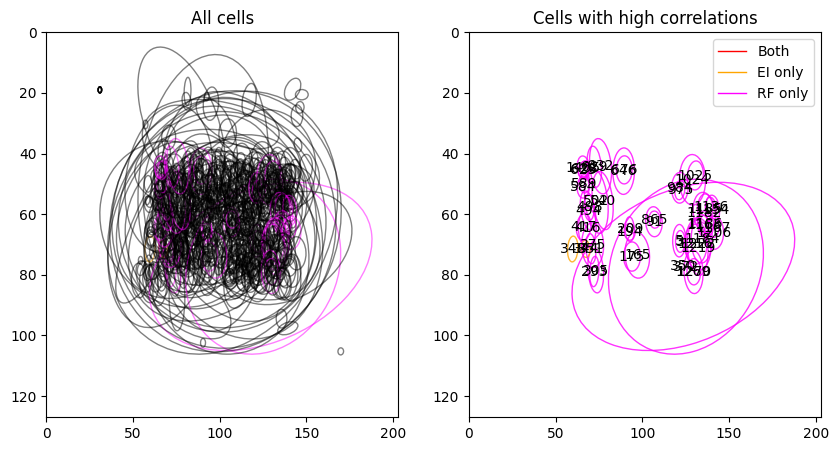

In [19]:
fig, ax = dd.plotRFs_dedup(ac)

/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


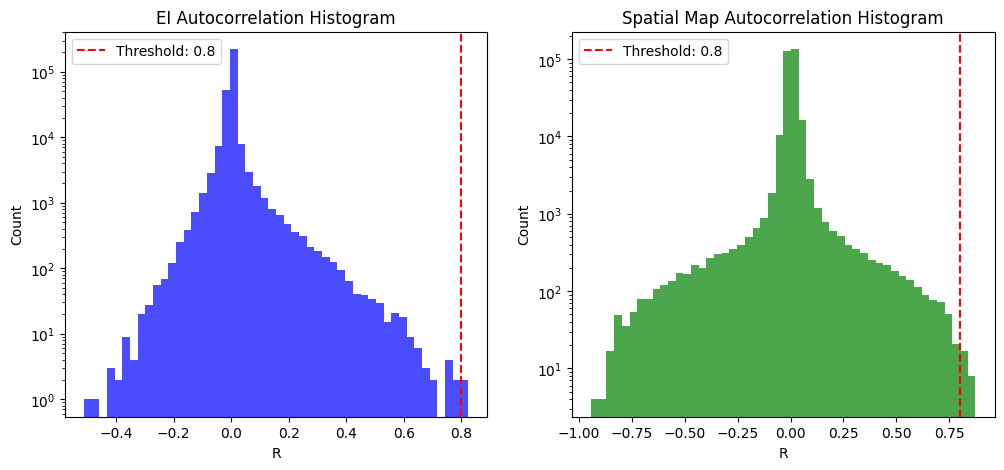

In [20]:
fig, ax = dd.plot_histograms(ac)